In [1]:
###carga las noticias relacionadas a la violencia de genero

import glob
import pandas as pd
csv_files = glob.glob('1-4mes/noticias relacionadas a la violencia de genero/*.csv')



list_data = []
  
for filename in csv_files:
    data = pd.read_csv(filename)
    list_data.append(data)
#Para chequear que todo está bien, mostramos la list_data por consola

 
data1 = pd.concat(list_data,ignore_index=True)
data1.drop('Unnamed: 0', axis=1, inplace=True)


In [2]:
csv_files = glob.glob('5-8mes/noticias relacionadas a la violencia de genero/*.csv')



list_data = []
  
for filename in csv_files:
    data = pd.read_csv(filename)
    list_data.append(data)
#Para chequear que todo está bien, mostramos la list_data por consola

 
data2 = pd.concat(list_data,ignore_index=True)
data2.drop('Unnamed: 0', axis=1, inplace=True)


In [3]:
csv_files = glob.glob('9-12mes/noticias relacionadas a la violencia de genero/*.csv')



list_data = []
  
for filename in csv_files:
    data = pd.read_csv(filename)
    list_data.append(data)
#Para chequear que todo está bien, mostramos la list_data por consola

 
data3 = pd.concat(list_data,ignore_index=True)
data3.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
data = pd.concat([data1, data2, data3], axis=0)
data.reset_index(drop='True',inplace=True)


In [ ]:
#data.to_csv('noticias relacionadas a la violencia de genero.csv')

In [6]:
noticias = data.text.values.tolist()

In [7]:
import spacy
from spacy.matcher import Matcher

In [8]:
nlp = spacy.load("es_core_news_md")

In [9]:
matcher = Matcher(nlp.vocab)

In [10]:
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

/home/fernando/miniconda3/envs/tal/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [11]:
pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
matcher.add("NOUN-de-NOUN", [pattern_1])

pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
matcher.add("NOUN-ADJ", [pattern_2])

In [12]:
def text_to_list(noticia):
    list_of_words = []
    
    try:
        doc = nlp(noticia)

        for token in doc:
            if (token.pos_=="NOUN"):
                list_of_words.append(token.text)

        for ent in doc.ents:
            if (ent.label_ == "PER" and " " in ent.text):
                list_of_words.append(ent.text)

        matches = matcher(doc)

        for match_id, start, end in matches:
            span = doc[start:end]  # The matched span
            list_of_words.append(span.text)
    
    except Exception as e: 
        print(noticia)
        print(e)
    
    return list_of_words

In [13]:
noticias_procesadas = []

for index, noticia in enumerate(noticias):
    print(index)
    noticia_procesada = text_to_list(noticia)
    noticias_procesadas.append(noticia_procesada)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(noticias_procesadas)
id2word

In [15]:
id2word[179]

'plataformas'

In [16]:
texts = noticias_procesadas

In [17]:
dataset = [id2word.doc2bow(noticia_procesada) for noticia_procesada in noticias_procesadas]

In [18]:
### NO CAMBIAR ESTA CELDA###

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #print(num_topics)
        
        model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        #print('hola')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
start=2
limit=15
step=2

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=dataset, texts=noticias_procesadas, start=start, limit=limit, step=step)

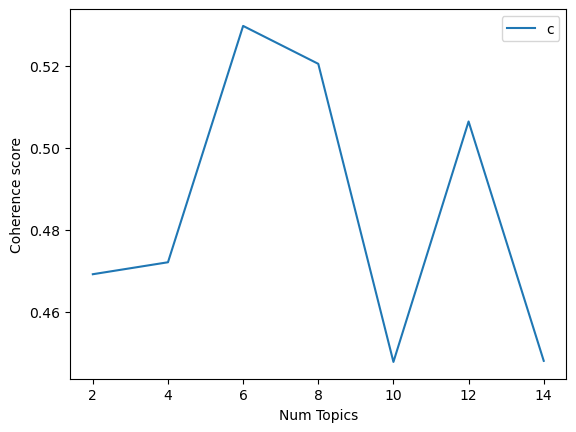

In [22]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [41]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [42]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, dataset, id2word)
vis

/home/fernando/miniconda3/envs/tal/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.198362  0.088797       1        1  39.898936
4      0.012741 -0.211373       2        1  19.115229
3     -0.112949 -0.031393       3        1  16.615334
1      0.193441  0.006506       4        1  15.797381
0      0.105129  0.147463       5        1   8.573120, topic_info=              Term        Freq       Total Category  logprob  loglift
41            años  749.000000  749.000000  Default  30.0000  30.0000
948          abuso  289.000000  289.000000  Default  29.0000  29.0000
1335  abuso sexual  255.000000  255.000000  Default  28.0000  28.0000
383      violencia  415.000000  415.000000  Default  27.0000  27.0000
520       imputado  490.000000  490.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
68       comunidad   20.056932  128.806118   Topic5  -5.6842   0.5968
366           tema   17.889330   63.920930   Topic5  -5.7986   1.1831
758       lesiones   21.947763  291.172370   Topic5  -5.5941  -0.1287
383      violencia   18.140717  415.759372   Topic5  -5.7846  -0.6754
791      sentencia   16.382795  153.154984   Topic5  -5.8866   0.2213

[366 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1812      3  0.974021      2014
4         1  0.036722      2020
4         2  0.018361      2020
4         3  0.009181      2020
4         4  0.697725      2020
...     ...       ...       ...
223       5  0.011864   víctima
468       1  0.202806  víctimas
468       2  0.185422  víctimas
468       3  0.266545  víctimas
468       4  0.336078  víctimas

[613 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 2, 1])

In [43]:
###  ¿Cuál es el tópico principal de cada documento?

In [44]:
def format_topics_documents(ldamodel=None, corpus=data, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_documents(ldamodel=optimal_model, corpus=dataset, texts=noticias)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

NameError: name 'corpus' is not defined